In [78]:
import sys
sys.path.append('..')

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.make_dataset import preprocess_cab_rides, preprocess_weather, merge_data

from src.features.build_features import feature_engineering
from src.models.train_model import train_model, evaluate_model
from src.utils.utils import load_model

import shap

In [80]:
cab_rides_raw = pd.read_csv('../data/raw/cab_rides.csv')
weather_raw = pd.read_csv('../data/raw/weather.csv')

In [81]:
cab_rides_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [82]:
cab_rides_raw.head(5)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [83]:
weather_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [84]:
weather_raw.head(5)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


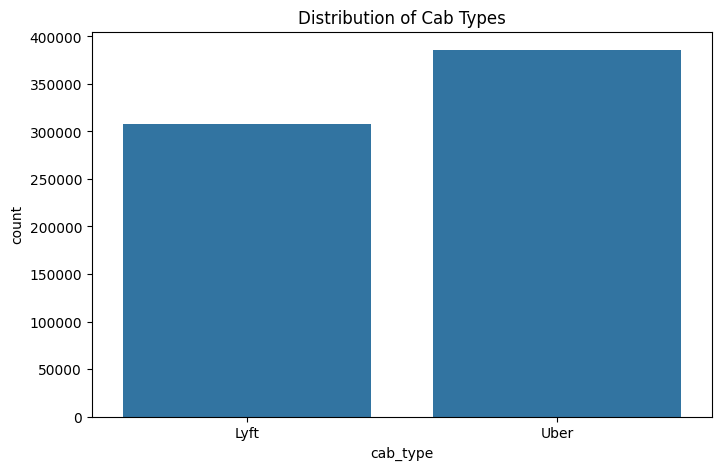

In [86]:
# Visualization 1: Distribution of Cab Types
plt.figure(figsize=(8, 5))
sns.countplot(x='cab_type', data=cab_rides_raw)
plt.title('Distribution of Cab Types')
plt.show()

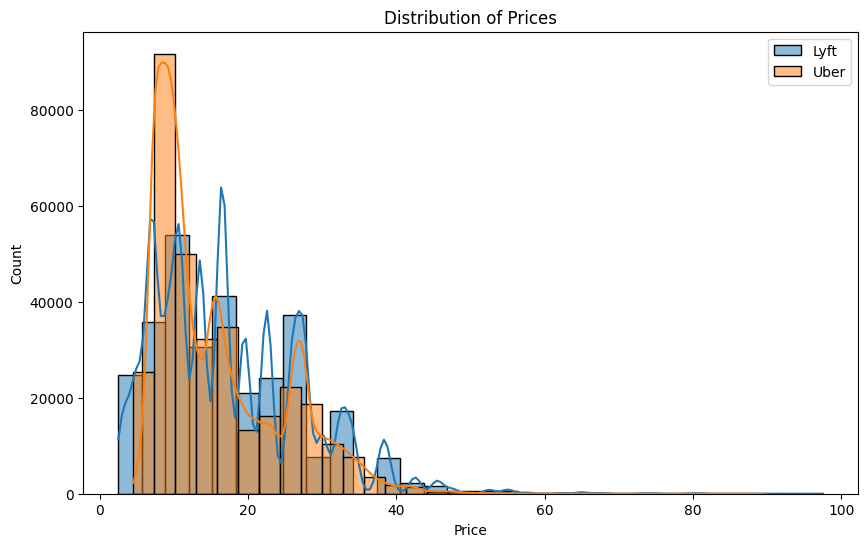

In [87]:
# Visualization 2: Distribution of Prices
plt.figure(figsize=(10, 6))
for cab_type in cab_rides_raw['cab_type'].unique():
    sns.histplot(cab_rides_raw[cab_rides_raw['cab_type'] == cab_type]['price'],
                 bins=30, kde=True, label=cab_type, alpha=0.5)

plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.legend()
plt.show()

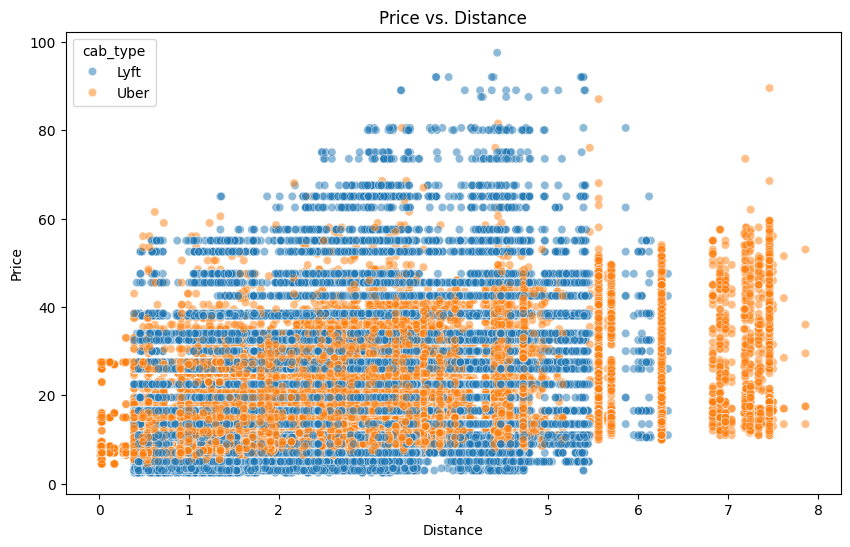

In [88]:
# Visualization 3: Price vs. Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='price', data=cab_rides_raw, hue='cab_type', alpha=0.5)
plt.title('Price vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


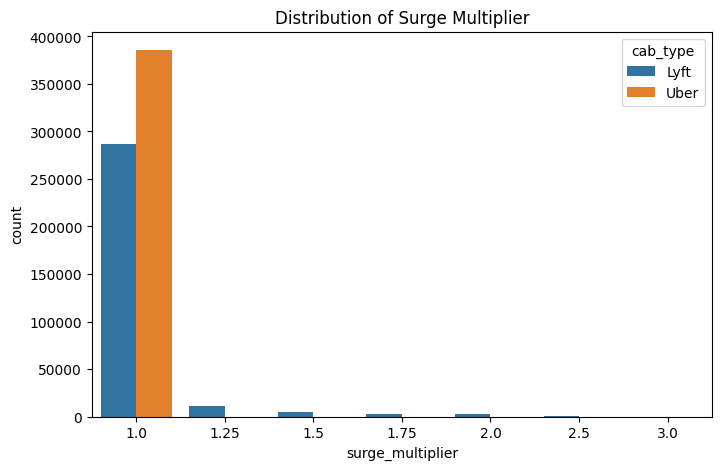

In [89]:
# Visualization 4: Surge Multiplier Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='surge_multiplier', data=cab_rides_raw, hue='cab_type')
plt.title('Distribution of Surge Multiplier')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



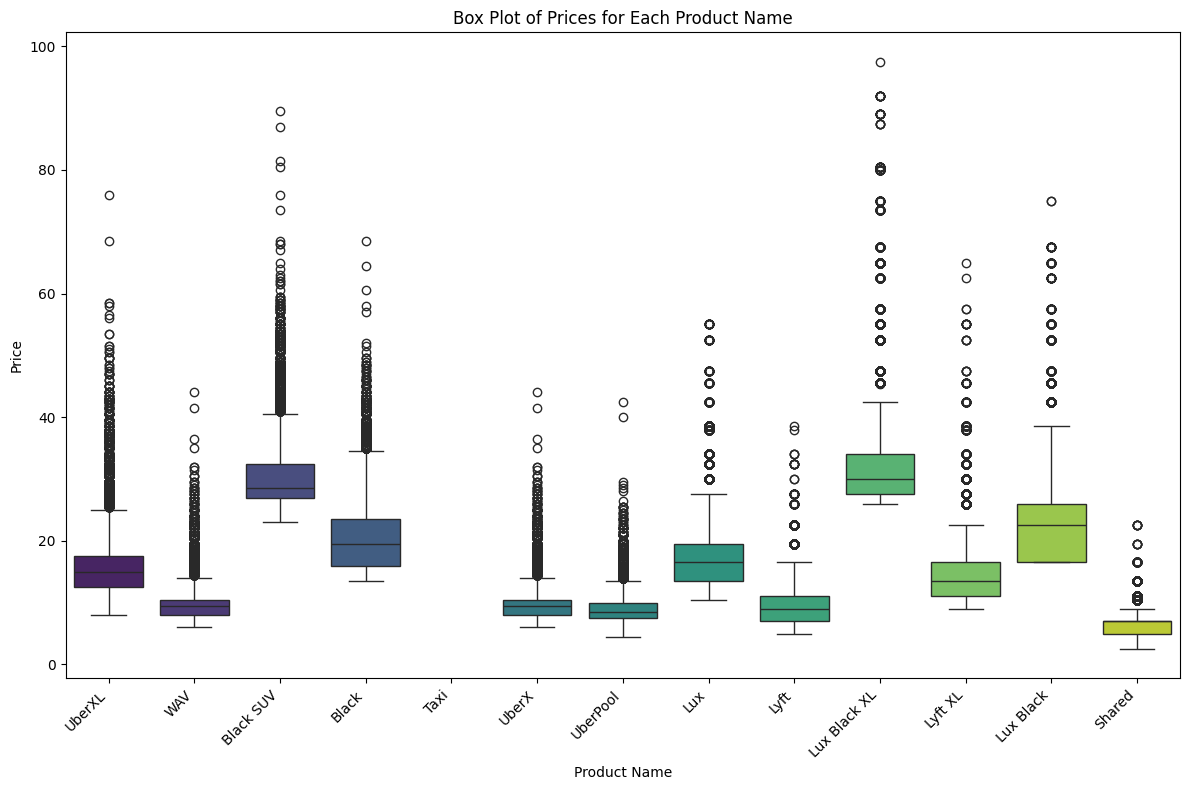

In [94]:
# Plotting the box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='name', y='price', data=cab_rides_raw, order=cab_rides_raw['name'].value_counts().index, palette='viridis')
plt.title('Box Plot of Prices for Each Product Name')
plt.xlabel('Product Name')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## Preprocessing

In [96]:
# Sort the data by the timestamp column
cab_rides_raw = cab_rides_raw.sort_values('time_stamp').reset_index(drop=True)

# Split the data into train and test sets
train_size = 0.8  
split_index = int(train_size * len(cab_rides_raw))

train_cab_rides_raw = cab_rides_raw.iloc[:split_index]
test_cab_rides_raw = cab_rides_raw.iloc[split_index:]

In [97]:
train_cab_rides_interim = preprocess_cab_rides(train_cab_rides_raw)
weather_interim = preprocess_weather(weather_raw)
train_merged_interim = merge_data(train_cab_rides_interim, weather_interim)

## Feature Engineering

In [98]:
train_processed_data = feature_engineering(train_merged_interim)

In [99]:
# Defining models I want to test. 
model_names = ['LightGBM', 'NeuralNetwork']

# Dictionary to store model performances
model_performances = {}

In [106]:
# Preprocessing test data in the same manner as train data
test_cab_rides_interim = preprocess_cab_rides(test_cab_rides_raw)
test_merged_interim = merge_data(test_cab_rides_interim, weather_interim)
test_processed_data = feature_engineering(test_merged_interim)

X_test = test_processed_data.drop('price', axis=1)
y_test = test_processed_data['price']

## Modelling & Evaluation

In [23]:
# Train and evaluate each model
for model_name in model_names:
    train_model(train_processed_data, model_name)

    # Load the trained model
    model_path = f'{model_name}.pkl'
    trained_model = load_model(model_path)

    # Evaluate model performance
    smape = evaluate_model(trained_model, X_test, y_test)
    
    # Store model performance
    model_performances[model_name] = {'model': trained_model, 'test_smape': smape}


INFO:root:Tuning hyperparameters for LightGBM using RandomizedSearchCV...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 510307, number of used features: 26
[LightGBM] [Info] Start training from score 2.728659


INFO:root:Best hyperparameters for LightGBM: {'model__regressor__num_leaves': 100, 'model__regressor__n_estimators': 100, 'model__regressor__min_child_samples': 100, 'model__regressor__max_depth': 10, 'model__regressor__learning_rate': 0.1}
INFO:root:Mean SMAPE for LightGBM: 7.842396153421673
INFO:root:Std SMAPE for LightGBM: 0.10102638150060159
INFO:root:Metrics for LightGBM: [7.99642048 7.91516215 7.78121028 7.80732829 7.71185957]
INFO:root:Best LightGBM model saved.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


INFO:root:Tuning hyperparameters for NeuralNetwork using RandomizedSearchCV...
c:\Users\Bekarys\Desktop\my-projects\epam-data-science-test-task\epam_ds_task_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
INFO:root:Best hyperparameters for NeuralNetwork: {'model__regressor__hidden_layer_sizes': (50,), 'model__regressor__alpha': 0.01}
INFO:root:Mean SMAPE for NeuralNetwork: 31.758892602922366
INFO:root:Std SMAPE for NeuralNetwork: 31.403088663342267
INFO:root:Metrics for NeuralNetwork: [91.40121382 35.68209716 13.28053473  9.59989215  8.83072515]
INFO:root:Best NeuralNetwork model saved.


In [24]:
model_performances

{'LightGBM': {'model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                              inverse_func=<ufunc 'expm1'>,
                                              regressor=LGBMRegressor(max_depth=10,
                                                                      min_child_samples=100,
                                                                      num_leaves=100)))]),
  'test_smape': 7.737494804011552},
 'NeuralNetwork': {'model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                              inverse_func=<ufunc 'expm1'>,
                                              regressor=MLPRegressor(alpha=0.01,
                                                                     hidden_layer_sizes=(50,))))]),
  'test_smape': 8.8454990611

**Summary of Observations from Model Performances**

- LightGBM consistently outperforms MLP in terms of Symmetric Mean Absolute Percentage Error (SMAPE) across multiple splits.
- SMAPE values for LightGBM are consistently lower, indicating superior predictive accuracy.
- MLP exhibits a noteworthy trend of improvement in SMAPE values after each split, suggesting potential for learning and adaptation.
- Despite LightGBM's overall superiority, the evolving performance of MLP indicates a potential for closing the performance gap with further optimization or training iterations.


## Prediction Explanations

### LightGBM

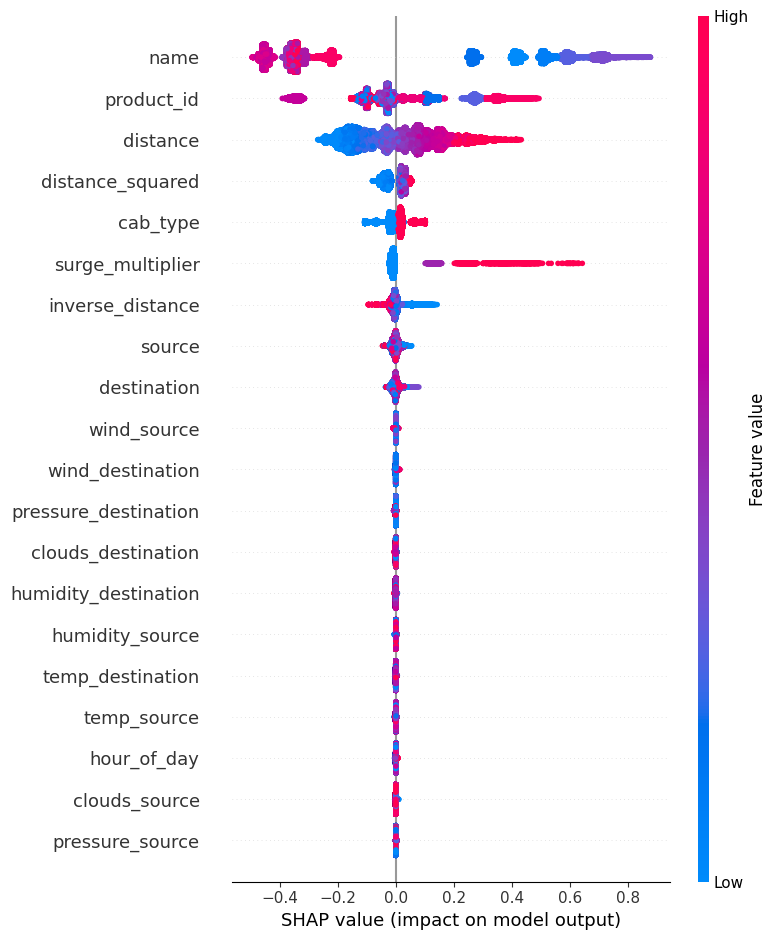

In [53]:
# Explain the model's predictions using SHAP values
trained_regressor = model_performances['LightGBM']['model']['model'].regressor_
explainer = shap.TreeExplainer(trained_regressor)

observations = model_performances['LightGBM']['model']['scaler'].transform(X_test)
#observations = model_performances['LightGBM']['model']['model'].transform(X_test)
shap_values = explainer.shap_values(observations)

feature_names = X_test.columns
# Summary plot of feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [ ]:
# Run initjs() to initialize JavaScript support
shap.initjs()

In [64]:
# Explain a single prediction
sample_index = 0  # Adjust the index based on the sample you want to explain
shap.force_plot(explainer.expected_value, shap_values[sample_index, :], X_test.iloc[sample_index, :], feature_names=feature_names)

In [73]:
test_cab_rides_interim.iloc[sample_index, :]

distance                                  1.37
cab_type                                  Lyft
time_stamp          2018-12-15 17:15:09.289000
destination                        Beacon Hill
source                        Haymarket Square
price                                     10.5
surge_multiplier                           1.0
product_id                           lyft_plus
name                                   Lyft XL
Name: 554456, dtype: object

**Summary of Observations from SHAP Analysis**

- The SHAP (SHapley Additive exPlanations) analysis provides insights into the influential features affecting predicted prices in the model.

- Key Influential Features:
  - **Name:** The product name significantly impacts the price, lowering it in certain instances.
  - **Product_ID:** Product type is a crucial determinant, affecting prices based on the specific product.
  - **Distance:** Distance is a major factor influencing prices, as expected.
  - **Surge_Multiplier:** Surge multiplier has a noticeable impact on prices, with higher multipliers leading to increased prices.

- Specific Instance:
  - For a particular instance, the product type (Lyft Plus) increased the price, contrary to the short distance, which typically lowers prices.
  - The product name also played a role in lowering the price for this specific instance, suggesting potential nuances in pricing.

- Rain Influence:
  - Contrary to initial expectations, rain did not appear in the feature importance list, indicating that its impact on prices might not be as significant as anticipated.

- Further Investigation:
  - The unexpected influence of product name on pricing warrants additional exploration to understand its specific impact.
  - While distance and surge multiplier align with expectations, there may be underlying factors affecting the model's predictions.

These observations provide valuable insights for refining the model and understanding the complex relationships between features and predicted prices.
